# **Relatório de Desenvolvimento de Modelo Preditivo para o Preço por Barril do Petróleo Bruto Tipo Brent para Tomada de Decisão**
Este projeto visa prever o preço do petróleo Brent usando um modelo LSTM. Utilizaremos dados históricos obtidos do Yahoo Finance para treinar e avaliar o modelo..

# Importação de Bibliotecas
Importamos bibliotecas essenciais para manipulação de dados, visualização e construção do modelo de previsão.

In [115]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.seasonal import seasonal_decompose #decomposição
from statsmodels.tsa.stattools import adfuller #teste Estatistico de Fuller (PValue)
import statistics as st 
import warnings
warnings.filterwarnings("ignore")
import scipy

# Aquisição e Preparação dos Dados
Os dados são importados do Yahoo Finance e incluem preços de fechamento, volume e taxa de câmbio do dólar. Realizamos o tratamento de dados faltantes e uma análise exploratória inicial.

Utilizamos a biblioteca Python 'yfinance' que possui os dados diários através do link(https://finance.yahoo.com/quote/BZ=F/history/)


O Yahoo Finance fornece dados diários para o preço do Petróleo Brent, incluindo as seguintes colunas:

- Open: Preço de abertura do dia do barril de petróleo (sem ajuste).
- High: Maior preço alcançado no dia pelo barril de petróleo (sem ajuste).
- Low: Menor preço alcançado no dia pelo barril de petróleo (sem ajuste).
- Close: Preço de fechamento do dia do barril de petróleo (sem ajuste).
- Adj Close: Preço de fechamento ajustado do barril de petróleo. Embora o ajuste para dividendos não se aplique a commodities, este campo pode refletir ajustes para outros fatores, como splits de contratos futuros.
- Volume: Volume de contratos negociados no dia.

In [116]:
# Especificando o período para importação dos dados
# start_date = '2007-07-30'
start_date = '2019-01-01'
end_date = '2024-11-19'

# Importando os dados
try:
    df_origem = yf.download('BZ=F', start=start_date, end=end_date)
except Exception as e:
    print(f"Erro ao baixar os dados: {e}")

[*********************100%***********************]  1 of 1 completed


In [117]:
# Visualizando os dados iniciais do dataframe com os dados importados
df_origem.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BZ=F,BZ=F,BZ=F,BZ=F,BZ=F,BZ=F
Date,,,,,,
2019-01-02,54.910000,54.910000,56.560001,52.500000,54.250000,43517
2019-01-03,55.950001,55.950001,56.290001,53.930000,54.770000,36535
2019-01-04,57.060001,57.060001,58.299999,55.360001,55.580002,42426
2019-01-07,57.330002,57.330002,58.919998,57.279999,57.369999,41677
2019-01-08,58.720001,58.720001,58.860001,57.110001,57.630001,34135


Ao importar dados do Yahoo Finance para o preço do Petróleo Brent, um nível adicional de índice, representando o `Ticker BZ=F`, foi incluído nas colunas do DataFrame.

Um `Ticker` é um símbolo usado para identificar ativos no mercado financeiro. No nosso caso, `BZ=F` refere-se aos contratos futuros de Petróleo Brent.

A presença do Ticker como um índice estava impactando negativamente a exploração dos dados, causando resultados inesperados ao aplicar filtros. Para simplificar, removemos esse nível de índice.

In [118]:
# Remover o nível de índice adicional
df_origem.columns = df_origem.columns.droplevel(1)
df_origem.head(10)

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2019-01-02,54.910000,54.910000,56.560001,52.500000,54.250000,43517
2019-01-03,55.950001,55.950001,56.290001,53.930000,54.770000,36535
2019-01-04,57.060001,57.060001,58.299999,55.360001,55.580002,42426
2019-01-07,57.330002,57.330002,58.919998,57.279999,57.369999,41677
2019-01-08,58.720001,58.720001,58.860001,57.110001,57.630001,34135
2019-01-09,61.439999,61.439999,61.680000,58.619999,58.650002,38989
2019-01-10,61.680000,61.680000,61.900002,60.450001,61.330002,31333
2019-01-11,60.480000,60.480000,62.470001,60.080002,61.250000,31369
2019-01-14,58.990002,58.990002,61.020000,58.910000,60.540001,31241


In [119]:
# Importando dados da taxa Dólar
usd_brl = yf.download('BRL=X', start= start_date, end=end_date)
usd_brl = usd_brl[['Close']].rename(columns={'Close':'Dolar'})
usd_brl.tail(10)

[*********************100%***********************]  1 of 1 completed


Price,Dolar
Ticker,BRL=X
Date,
2024-11-05,5.7906
2024-11-06,5.7398
2024-11-07,5.6748
2024-11-08,5.6910
2024-11-11,5.7364
2024-11-12,5.7554
2024-11-13,5.7482
2024-11-14,5.8059


Da mesma forma que ocorreu com a importação dos dados do Petróleo Brent (`BZ=F`), ao importar os dados da cotação do Dólar a linha Ticker correspondente foi apresentada (`BRL=X`). Removemos esse nível de índice.

In [120]:
# Remover o nível de índice adicional
usd_brl.columns = usd_brl.columns.droplevel(1)
usd_brl.head(10)

Price,Dolar
Date,
2019-01-01,3.8800
2019-01-02,3.8799
2019-01-03,3.7863
2019-01-04,3.7551
2019-01-07,3.6612
2019-01-08,3.7341
2019-01-09,3.7124
2019-01-10,3.6800
2019-01-11,3.7079


A função `tabela_unica` é utilizada para combinar dois DataFrames, criando uma tabela única que facilita a análise conjunta dos dados.

In [121]:
def tabela_unica(df, df_juncao):
    df_novo = df.merge(df_juncao, how = 'left',  left_on = df_origem.index, right_on = df_juncao.index)
    df_novo.rename(columns={'key_0':'Date'}, inplace = True)
    df_novo = df_novo.set_index('Date')
    return df_novo

Nesse ponto, fizemos a junção do dataframe com os dados do Petróleo Brent e do dataframe com o preço do fechamento do Dólar.

In [122]:
# Criando as tabelas usando a função `tabela_unica`
df_pretroleo_brent = tabela_unica(df_origem, usd_brl)
df_pretroleo_brent.head()

Price,Adj Close,Close,High,Low,Open,Volume,Dolar
Date,,,,,,,
2019-01-02,54.910000,54.910000,56.560001,52.500000,54.250000,43517,3.8799
2019-01-03,55.950001,55.950001,56.290001,53.930000,54.770000,36535,3.7863
2019-01-04,57.060001,57.060001,58.299999,55.360001,55.580002,42426,3.7551
2019-01-07,57.330002,57.330002,58.919998,57.279999,57.369999,41677,3.6612
2019-01-08,58.720001,58.720001,58.860001,57.110001,57.630001,34135,3.7341


Para prosseguir com a análise, foi criado um novo dataframe apenas com as seguintes colunas:
- `Close`: Preço de fechamento do dia do barril de petróleo (sem ajuste).
- `Volume`: Volume de contratos negociados no dia.
- `Dolar`: Preço do fechamento do Dólar

In [123]:
# Fechamento vs as demais variáveis
df_close = df_pretroleo_brent[['Close', 'Volume', 'Dolar']]
df_close

Price,Close,Volume,Dolar
Date,,,
2019-01-02,54.910000,43517,3.8799
2019-01-03,55.950001,36535,3.7863
2019-01-04,57.060001,42426,3.7551
2019-01-07,57.330002,41677,3.6612
2019-01-08,58.720001,34135,3.7341
...,...,...,...
2024-11-12,71.889999,38295,5.7554
2024-11-13,72.279999,43666,5.7482
2024-11-14,72.559998,32367,5.8059


# Análise Exploratória dos Dados
Exploramos a distribuição dos dados, visualizamos tendências e padrões sazonais, e calculamos estatísticas descritivas.

In [124]:
# Resumo informativo sobre o tipo de dados de cada coluna, contagem de valores não nulos e uso de memória.
df_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1482 entries, 2019-01-02 to 2024-11-18
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1482 non-null   float64
 1   Volume  1482 non-null   int64  
 2   Dolar   1481 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 46.3 KB


In [125]:
# Dimensão do DataFrame indicando o número de linhas e colunas.
df_close.shape

(1482, 3)

In [126]:
# Verificando se não há valores faltantes na base de dados.
df_close.isna().sum()

Price
Close     0
Volume    0
Dolar     1
dtype: int64

Durante a análise dos dados, foi identificado que a coluna `Dolar` do DataFrame contém valor(es) faltante(s) que pode(m) ser verificada(s) a seguir.

In [127]:
df_close[df_close['Dolar'].isna()]

Price,Close,Volume,Dolar
Date,,,
2019-05-22,70.989998,57458,NaN


Para lidar com os valores faltantes na coluna `Dolar`, utilizamos dados históricos obtidos do site do IPEA. Esses dados cobrem o período de 2007 a 2019. Criamos um dicionário para auxiliar no preenchimento dos valores ausentes.

In [128]:
# Dados obtidos do IPEA (http://www.ipeadata.gov.br/ExibeSerie.aspx?serid=38590&module=M)
dados_para_substituir = {
    '2007-09-10': 1.9583,
    '2007-11-26': 1.8102,
    '2007-12-18': 1.8083,
    '2007-12-26': 1.7787,
    '2008-04-01': 1.7493,
    '2008-05-01': 1.6458,
    '2008-07-01': 1.6053,
    '2008-08-01': 1.5585,
    '2008-08-04': 1.5651,
    '2008-08-05': 1.5724,
    '2008-08-06': 1.5774,
    '2008-08-07': 1.5835,
    '2008-08-08': 1.6128,
    '2008-08-11': 1.6140,
    '2008-08-12': 1.6153,
    '2008-08-13': 1.6203,
    '2008-08-14': 1.6196,
    '2008-08-15': 1.6381,
    '2008-08-18': 1.6341,
    '2008-08-19': 1.6335,
    '2008-08-20': 1.6199,
    '2008-08-21': 1.6135,
    '2008-08-22': 1.6209,
    '2008-08-25': 1.6267,
    '2009-04-13': 2.1691,
    '2009-06-01': 1.9432,
    '2011-04-15': 1.5768,
    '2013-01-16': 2.0403,
    '2013-10-08': 2.2010,
    '2017-07-11': 3.2534,
    '2017-11-16': 3.2802,
    '2019-05-22': 4.0222
}

# Substituir os valores NaN
for date, value in dados_para_substituir.items():
    if date >= start_date:
        df_close.loc[date, 'Dolar'] = value

In [129]:
#Verificando se ainda não há valores faltantes no DataFrame.
df_close.isna().sum()

Price
Close     0
Volume    0
Dolar     0
dtype: int64

In [130]:
df_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1482 entries, 2019-01-02 to 2024-11-18
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1482 non-null   float64
 1   Volume  1482 non-null   int64  
 2   Dolar   1482 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 78.6 KB


In [131]:
# Quantidade de duplicados
print('Volume de duplicados na amostra: ', df_close.duplicated().sum())

Volume de duplicados na amostra:  0


In [132]:
# Estatistica descritiva
df_close.describe()

Price,Close,Volume,Dolar
count,1482.000000,1482.000000,1482.000000
mean,73.152699,31168.372470,4.985675
std,19.184488,12394.095322,0.560027
min,19.330000,0.000000,3.642800
25%,62.290001,23485.250000,4.851950
50%,74.665001,30419.500000,5.141111
75%,84.667500,37451.000000,5.377650
max,127.980003,90111.000000,5.886400


In [133]:
#Variância
print(round(st.variance(df_close['Close']),1))

#Coeficiente de variação
print(round((st.sqrt(st.variance(df_close['Close']))/st.mean(df_close['Close'])),1)*100, '%')

368.0
30.0 %


In [134]:
# Modelo de ANOVA
model = ols('Close ~ Volume + Dolar', data=df_close).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq      df          F        PR(>F)
Volume     18788.697821     1.0  53.086831  5.171525e-13
Dolar       1008.553050     1.0   2.849633  9.160565e-02
Residual  523453.432117  1479.0        NaN           NaN


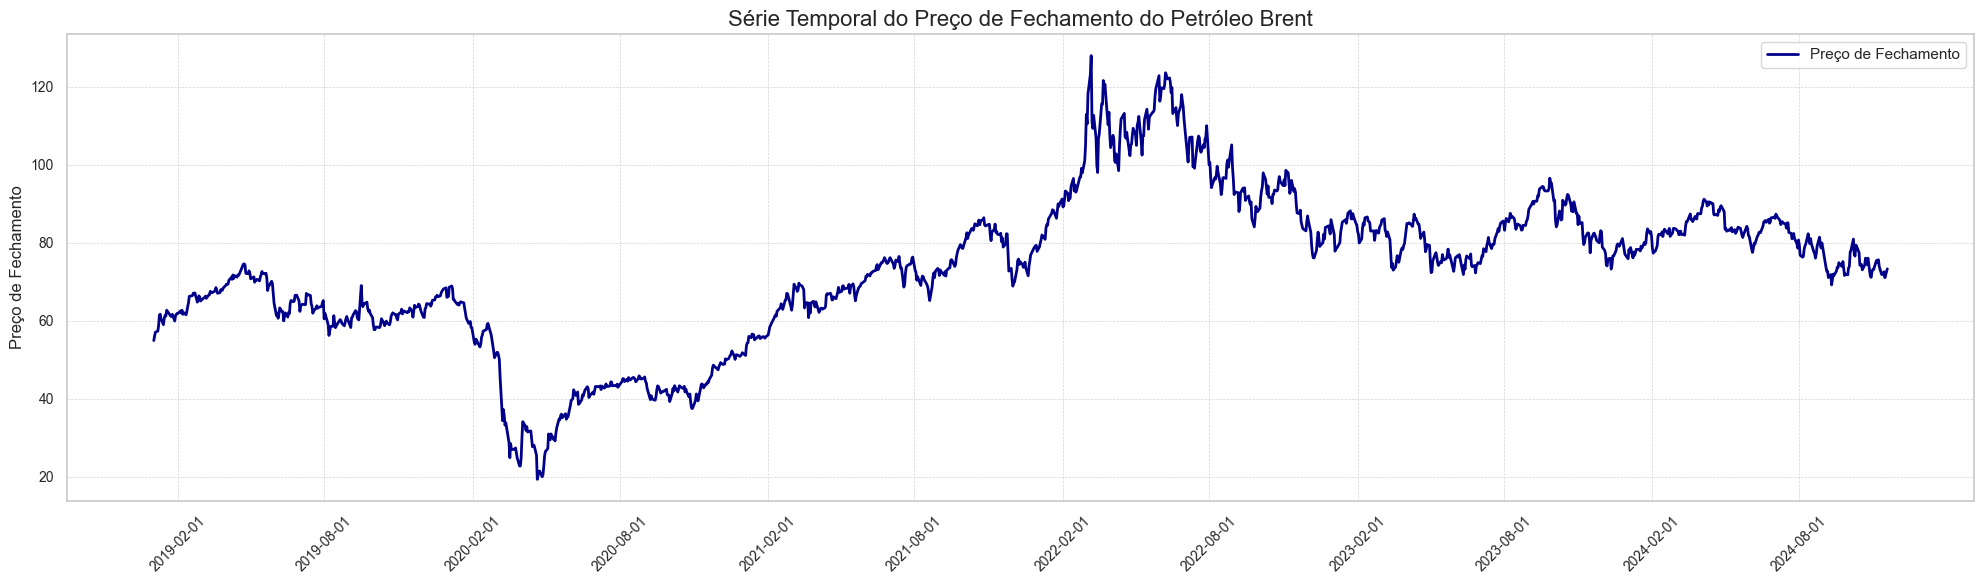

In [135]:
# Olhando a série de fechamento do Preço do Petróleo Brent
plt.figure(figsize=(20, 6))

# Plotando a linha de fechamento
plt.plot(df_close.index, df_close['Close'], linewidth=2, color='darkblue', label='Preço de Fechamento')

# Título e rótulos
plt.title('Série Temporal do Preço de Fechamento do Petróleo Brent', fontsize=16)
#plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço de Fechamento', fontsize=12)

# Linhas de grade
plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5, color='lightgray')

# Ajustar os ticks do eixo x para exibir por n meses
plt.xticks(
    pd.date_range(start=df_close.index.min(), end=df_close.index.max(), freq='6MS'),
    rotation=45,
    fontsize=10
)

# Ajustar os ticks do eixo y
plt.yticks(fontsize=10)

# Adicionando uma legenda
plt.legend()

# Melhorar o layout
plt.tight_layout()

# Mostrando o gráfico
plt.show()

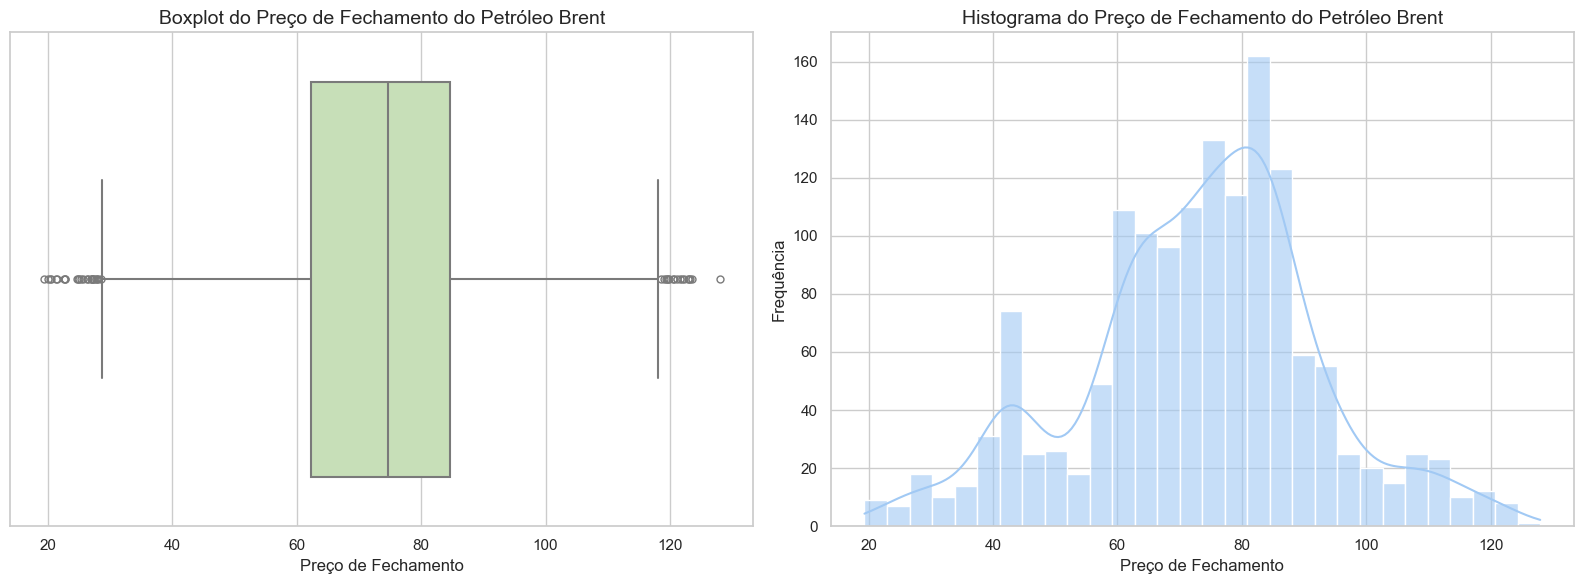

In [136]:
# Configurar o estilo do gráfico
sns.set(style="whitegrid")

# Criar a figura com dois subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotar o boxplot no primeiro subplot
sns.boxplot(x='Close', data=df_close, ax=axes[0], whis=1.5, color='#c6e5b1', fliersize=5, linewidth=1.5)
axes[0].set_title('Boxplot do Preço de Fechamento do Petróleo Brent', fontsize=14)
axes[0].set_xlabel('Preço de Fechamento', fontsize=12)

# Plotar o histograma com KDE no segundo subplot
sns.histplot(df_close['Close'], bins=30, ax=axes[1], color='#a1c9f4', alpha=0.6, kde=True)
axes[1].set_title('Histograma do Preço de Fechamento do Petróleo Brent', fontsize=14)
axes[1].set_xlabel('Preço de Fechamento', fontsize=12)
axes[1].set_ylabel('Frequência', fontsize=12)

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar os gráficos
plt.show()

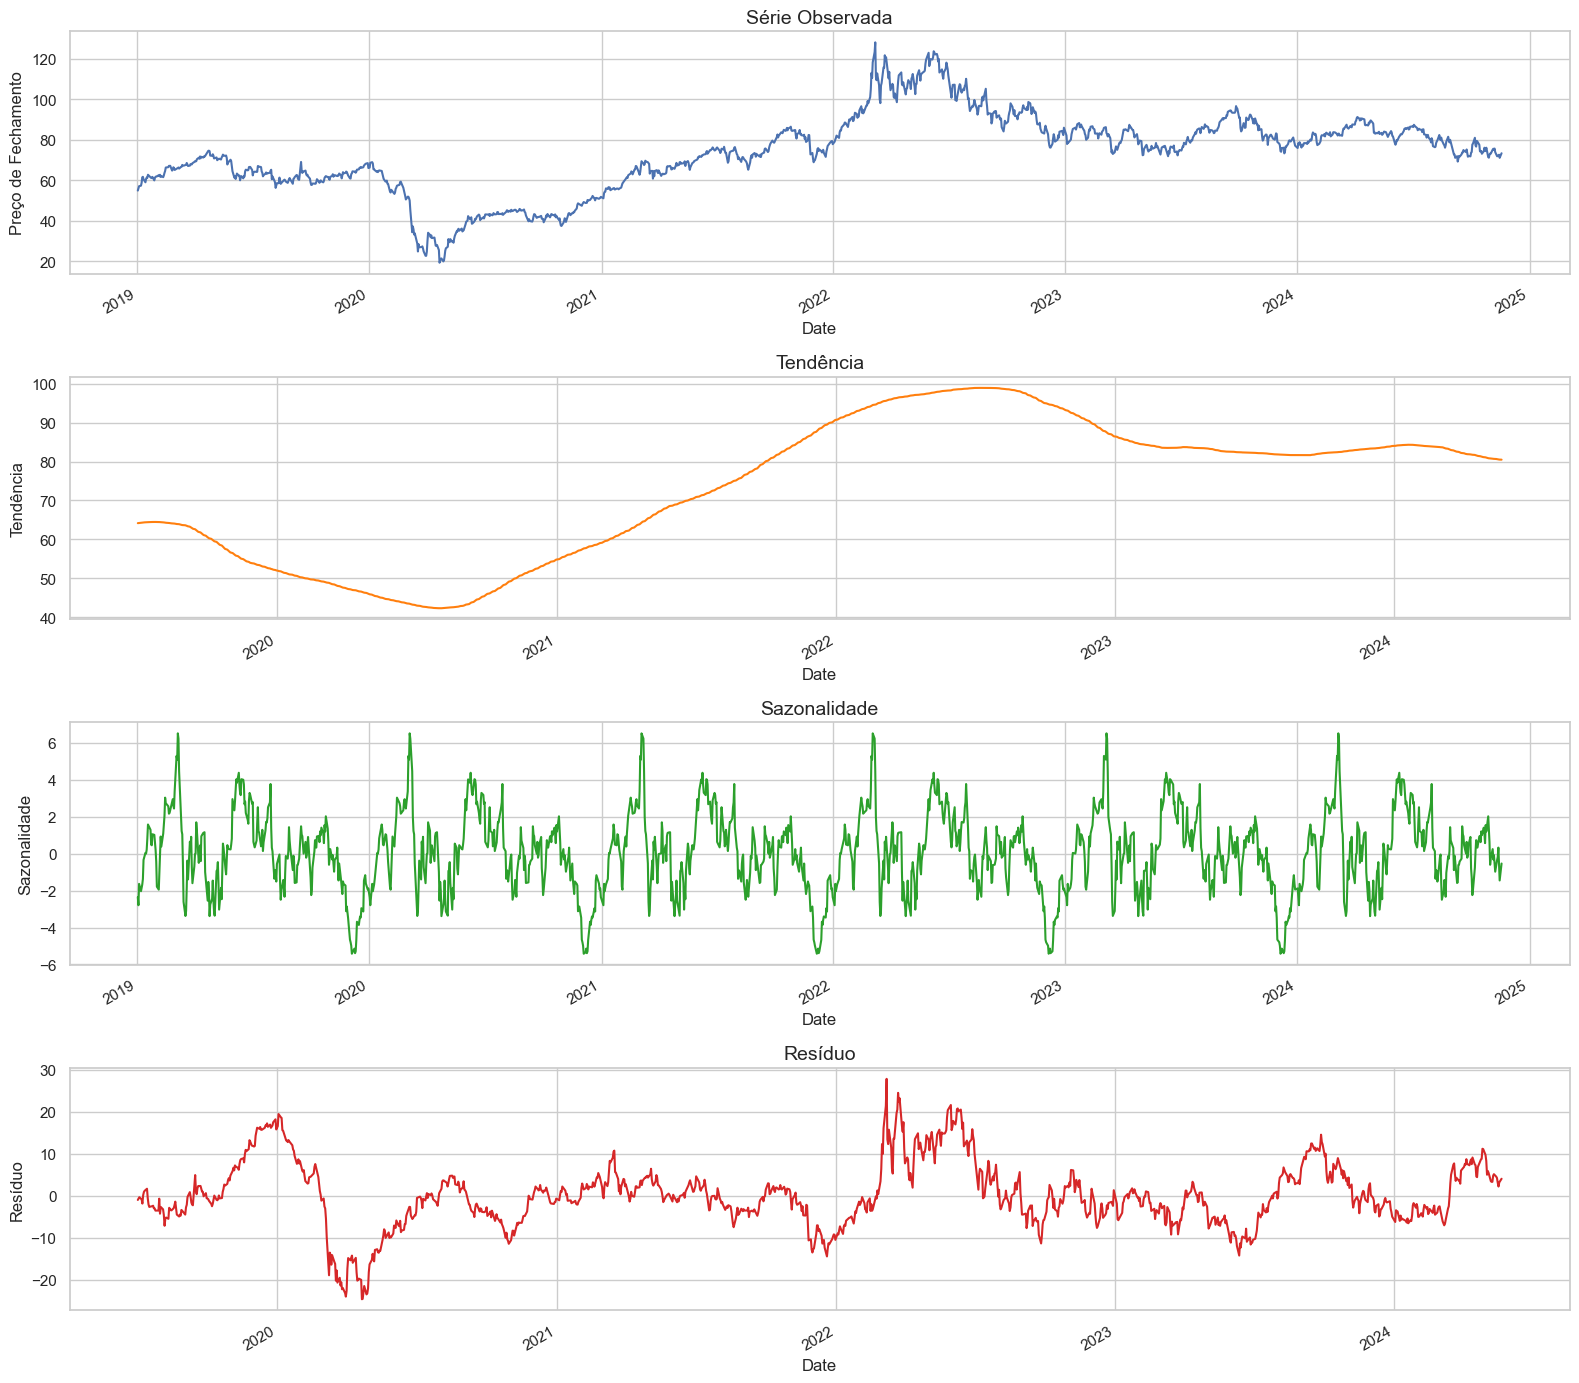

In [137]:
# Decomposição da série 
resultados = seasonal_decompose(df_close['Close'], period=252)

# Plotando
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(16,14))

# Série
resultados.observed.plot(ax=ax1, title = 'Série')
ax1.set_title('Série Observada', fontsize=14)
ax1.set_ylabel('Preço de Fechamento', fontsize=12)
ax1.grid(True)

# Tendência
resultados.trend.plot(ax=ax2, color='#ff7f0e')
ax2.set_title('Tendência', fontsize=14)
ax2.set_ylabel('Tendência', fontsize=12)
ax2.grid(True)

# Sazonalidade
resultados.seasonal.plot(ax=ax3, color='#2ca02c')
ax3.set_title('Sazonalidade', fontsize=14)
ax3.set_ylabel('Sazonalidade', fontsize=12)
ax3.grid(True)

# Resíduo
resultados.resid.plot(ax=ax4, color='#d62728')
ax4.set_title('Resíduo', fontsize=14)
ax4.set_ylabel('Resíduo', fontsize=12)
ax4.grid(True)

plt.tight_layout()

## Teste de Dickey-Fuller Aumentado (ADF)

O Teste de Dickey-Fuller Aumentado (ADF) é um teste estatístico usado para verificar a presença de uma raiz unitária em uma série temporal, o que ajuda a determinar se a série é estacionária. A estacionariedade é uma característica importante em séries temporais, pois muitas técnicas de modelagem assumem que a série é estacionária.

Na execução a seguir, dado que o `Teste Estatístico` (-1.6116) não é menor que os `Valores Críticos` e o `P-Value` (0.4772) é bem maior que `0.05`, não há evidência suficiente para rejeitar a hipótese nula de que a série temporal possui uma raiz unitária. Portanto, concluímos que a série não é estacionária.

In [138]:
# Teste Estatístico - Fuller
X = df_close.Close.values
results = adfuller(X)

print("Teste ADF")
print(f"Teste Estatistico: {results[0]}")
print(f"P-Value: {results[1]}")
print("Valores criticos:")

for key, value in results[4].items():
  print(f"{key}: {value}")

Teste ADF
Teste Estatistico: -1.6115507650194494
P-Value: 0.477161593410211
Valores criticos:
1%: -3.434791163965702
5%: -2.8635014840083945
10%: -2.5678142741740877


In [139]:
#Teste de normalidade dos dados
scipy.stats.shapiro(df_close.Close)

ShapiroResult(statistic=np.float64(0.98558061585351), pvalue=np.float64(5.419368576173395e-11))

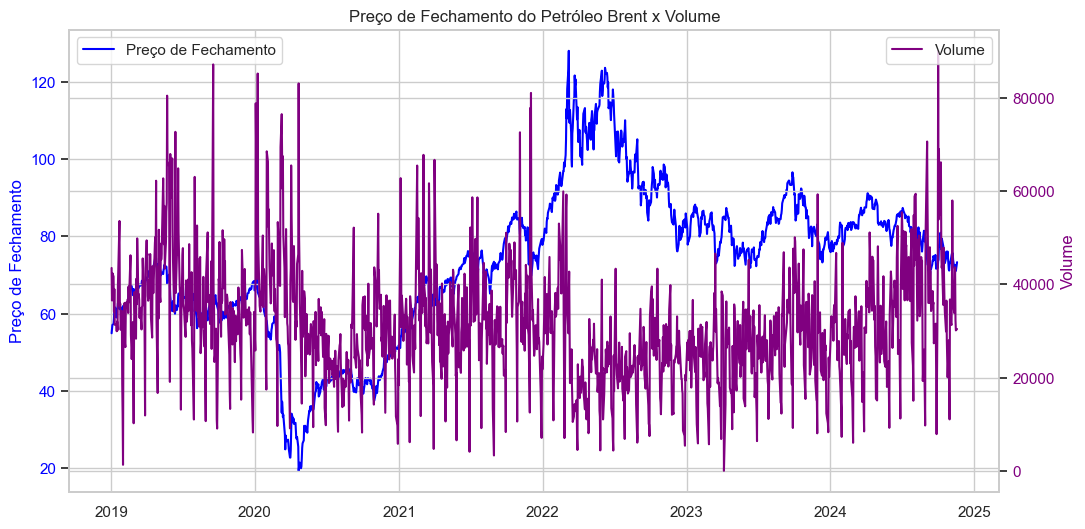

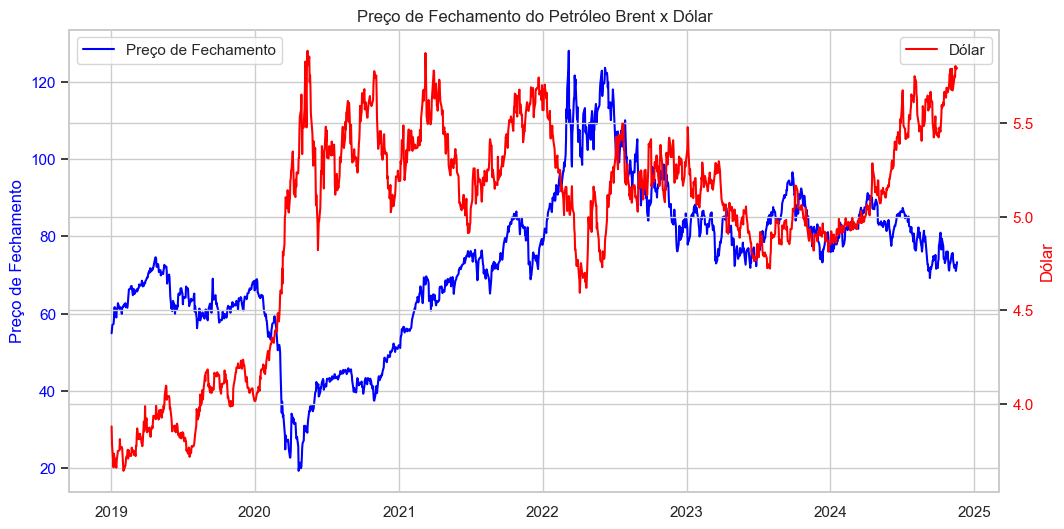

In [163]:
# Criando a primeira figura para comparação entre Close Price e Volume
fig1, ax1 = plt.subplots(figsize=(12, 6))  # Apenas um gráfico na primeira figura

# Gráfico 1: Close Price vs. Volume
ax1.plot(df_close.index, df_close['Close'], color='blue', label='Preço de Fechamento')
# ax1.set_xlabel('Data')
ax1.set_ylabel('Preço de Fechamento', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Adicionando o Volume no mesmo gráfico
ax2 = ax1.twinx()  # Cria um segundo eixo y que compartilha o mesmo eixo x
ax2.plot(df_close.index, df_close['Volume'], color='purple', label='Volume')
ax2.set_ylabel('Volume', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# Título e legendas
ax1.set_title('Preço de Fechamento do Petróleo Brent x Volume')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Criando a segunda figura para comparação entre Close Price e Dolar
fig2, ax3 = plt.subplots(figsize=(12, 6))  # Apenas um gráfico na segunda figura

# Gráfico 2: Close Price vs. Dolar
ax3.plot(df_close.index, df_close['Close'], color='blue', label='Preço de Fechamento')
# ax3.set_xlabel('Data')
ax3.set_ylabel('Preço de Fechamento', color='blue')
ax3.tick_params(axis='y', labelcolor='blue')

# Adicionando o Dolar no mesmo gráfico
ax4 = ax3.twinx()  # Cria um segundo eixo y que compartilha o mesmo eixo x
ax4.plot(df_close.index, df_close['Dolar'], color='red', label='Dólar')
ax4.set_ylabel('Dólar', color='red')
ax4.tick_params(axis='y', labelcolor='red')

# Título e legendas
ax3.set_title('Preço de Fechamento do Petróleo Brent x Dólar')
ax3.legend(loc='upper left')
ax4.legend(loc='upper right')

# Exibir os gráficos
plt.show()

##### Análise de Correlação

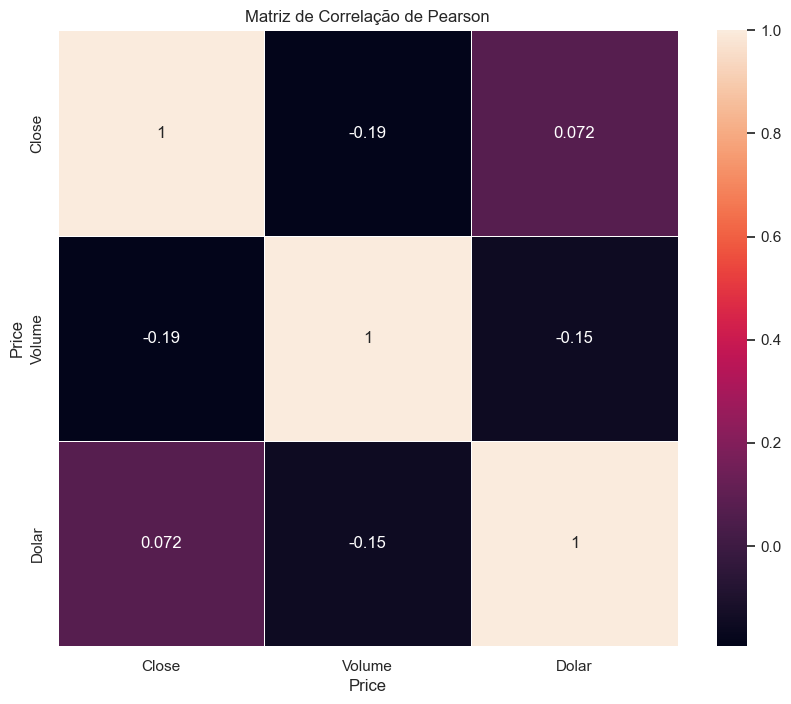

In [141]:
#Cria a matriz de correlação
correlation_matrix = df_close.corr()

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)
plt.title('Matriz de Correlação de Pearson')
plt.show()

<Axes: title={'center': 'Correlação de Spearman'}, xlabel='Price', ylabel='Price'>

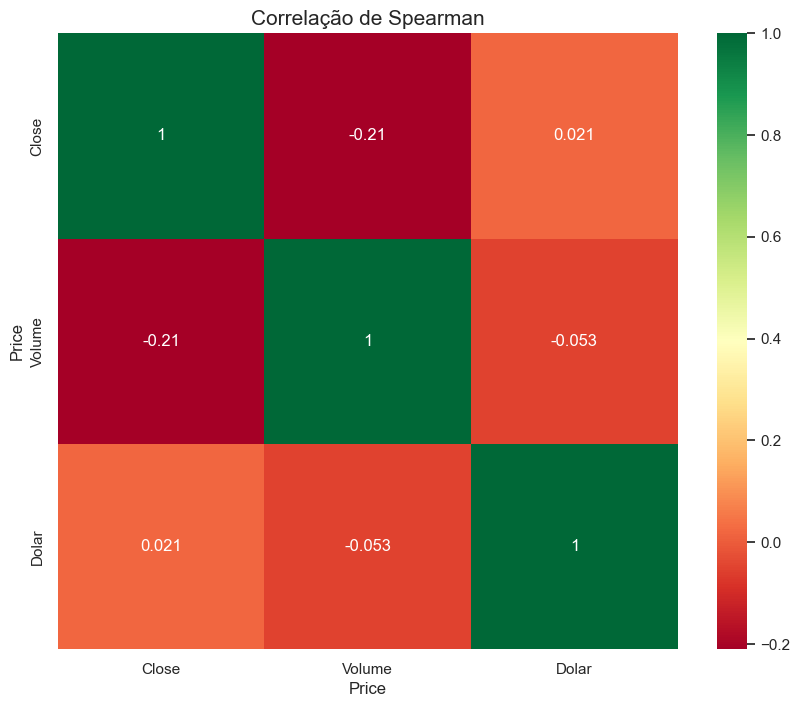

In [142]:
#Correlograma com a correlação de Spearman.
plt.figure(figsize=(10,8))
plt.title('Correlação de Spearman',size=15)
sns.heatmap(df_close.corr('spearman'), annot = True, cmap= "RdYlGn")

##### Estudo de outliers

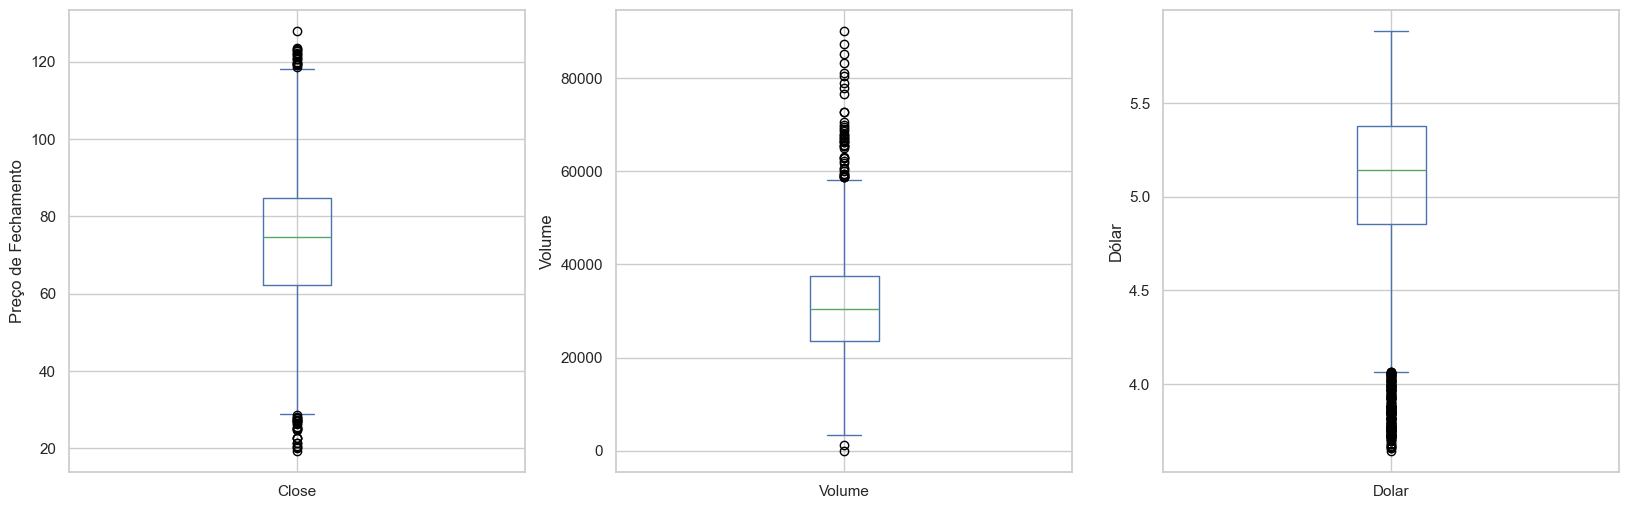

In [173]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 6))

# Gráfico 1 Close
df_close['Close'].plot.box(ax = ax1)
ax1.set_ylabel('Preço de Fechamento')

# Gráfico 2 - Volume
df_close['Volume'].plot.box(ax = ax2)
ax2.set_ylabel('Volume')

# Gráfico 3 Dollar
df_close['Dolar'].plot.box(ax = ax3)
ax3.set_ylabel('Dólar')

plt.show()

##### Distribuição

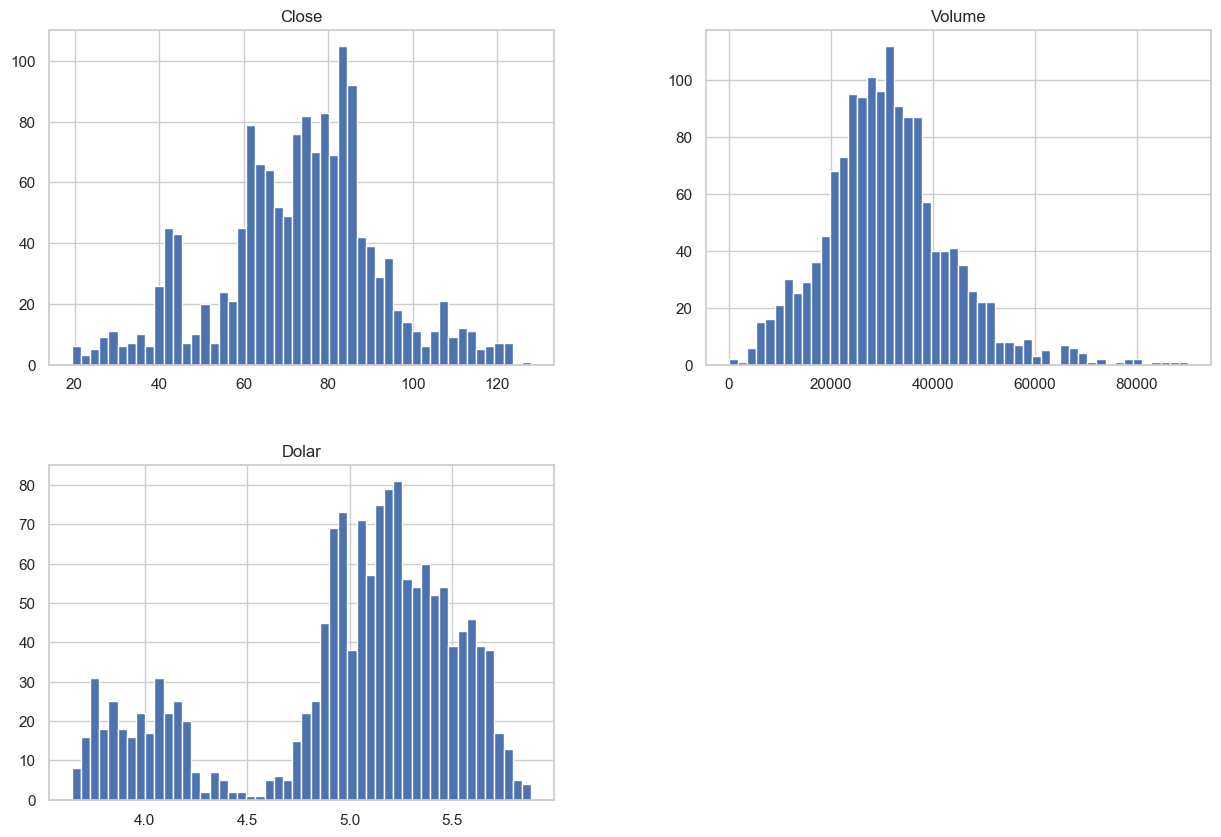

In [144]:
df_close[['Close', 'Volume', 'Dolar']].hist(figsize=(15,10), bins=50);

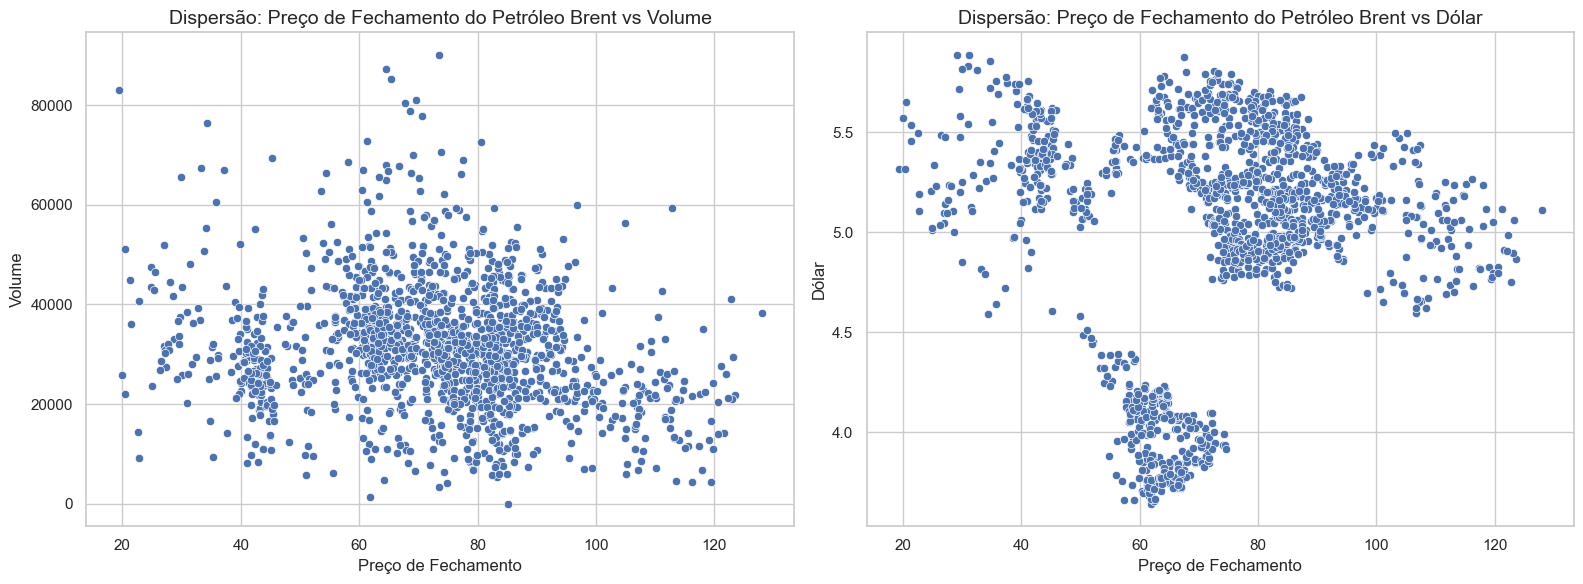

In [165]:
# Gráfico de dispersão entre as variáveis
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de dispersão entre Close e Volume
sns.scatterplot(x='Close', y='Volume', data=df_close, ax=ax[0])
ax[0].set_title('Dispersão: Preço de Fechamento do Petróleo Brent vs Volume', fontsize=14)
ax[0].set_xlabel('Preço de Fechamento', fontsize=12)
ax[0].set_ylabel('Volume', fontsize=12)

# Gráfico de dispersão entre Close e Dolar
sns.scatterplot(x='Close', y='Dolar', data=df_close, ax=ax[1])
ax[1].set_title('Dispersão: Preço de Fechamento do Petróleo Brent vs Dólar', fontsize=14)
ax[1].set_xlabel('Preço de Fechamento', fontsize=12)
ax[1].set_ylabel('Dólar', fontsize=12)

# Exibir os gráficos
plt.tight_layout()  
plt.show()

##### Análise de Variância (ANOVA)

##### ANOVA: Avalia a significância estatística das variáveis independentes.

In [146]:
# Modelo de ANOVA
model = ols('Close ~ Volume + Dolar', data=df_close).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq      df          F        PR(>F)
Volume     18788.697821     1.0  53.086831  5.171525e-13
Dolar       1008.553050     1.0   2.849633  9.160565e-02
Residual  523453.432117  1479.0        NaN           NaN


# Modelo de Previsão LSTM (Long Short-Term Memory)

Para gerar previsões em séries temporais, utilizaremos o modelo LSTM (Long Short-Term Memory), uma variante das Redes Neurais Recorrentes (RNNs). O LSTM é particularmente eficaz no aprendizado de padrões de longo prazo em dados sequenciais, graças à sua capacidade de manter informações relevantes ao longo do tempo e descartar informações irrelevantes.

O LSTM é amplamente utilizado em previsões de séries temporais devido à sua habilidade de capturar dependências temporais complexas, tornando-o ideal para o nosso conjunto de dados. A arquitetura do LSTM inclui células de memória e mecanismos de portas que regulam o fluxo de informações, permitindo que o modelo aprenda e generalize de maneira eficaz a partir dos dados históricos.

In [147]:
# Importação de bibliotecas para execução do modelo de LSTM e avaliação do modelo

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import random

In [148]:
# Criar um DataFrame para execução do modelo
df_LSTM = df_close[['Close']]

## Salvando Arquivo para Uso no Streamlit

Este trecho de código é responsável por salvar os dados processados em um arquivo CSV, que será utilizado posteriormente em aplicações desenvolvidas com o Streamlit.

In [149]:
# Salva os dados em um CSV
df_LSTM.to_csv('dados_petroleo.csv') 

## Preparação dos Dados para o Modelo

In [150]:
# Definir a semente para reprodutibilidade
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

## Normalização dos Dados
A normalização dos dados é uma etapa importante no pré-processamento para modelos LSTM, garantindo que as variáveis sejam escaladas para um intervalo uniforme, geralmente entre 0 e 1. Isso é feito para melhorar a eficiência e a convergência do treinamento do modelo.

In [151]:
# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_LSTM)

## Separação dos Dados e Conjuntos de Treino e Teste

A divisão dos dados em conjuntos de treino e teste é uma etapa fundamental na modelagem de séries temporais, pois permite avaliar a capacidade de generalização do modelo em dados não vistos anteriormente. Para este projeto, adotaremos a proporção de 80% dos dados para treino e 20% para teste, seguindo as melhores práticas de modelagem.

In [152]:
# Criar o conjunto de dados para treino e teste
# 80% para Treino e 20% para Teste
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [153]:
# Função para criar uma estrutura de dados adequada para LSTM

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]
        X.append(a)
        Y.append(dataset[i + time_step, 0])  # '0' é a coluna de fechamento
    return np.array(X), np.array(Y)

time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [154]:
# Redimensionar os dados para [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

## Construção do Modelo LSTM
O modelo LSTM é construído com duas camadas LSTM e camadas densas subsequentes. Utilizamos o otimizador Adam e a função de perda de erro quadrático médio.

In [155]:
# Criar o modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [156]:
# Treinar o modelo
model.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0117
Epoch 2/10
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0026
Epoch 3/10
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0016
Epoch 4/10
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0016
Epoch 5/10
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0017
Epoch 6/10
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0019
Epoch 7/10
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0014
Epoch 8/10
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0013
Epoch 9/10
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0014
Epoch 10/10
1164/1164 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0013


In [157]:
# Fazer previsões
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


## Reversão da Normalização

Após o treinamento e a previsão com o modelo LSTM, é necessário reverter a normalização dos dados para interpretar os resultados no contexto original dos dados. Isso permite que as previsões sejam comparadas diretamente com os valores reais em suas unidades originais.

In [158]:
# Reverter a normalização
train_predict = scaler.inverse_transform(
    np.concatenate((train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1] - 1))), axis=1)
)[:, 0]
test_predict = scaler.inverse_transform(
    np.concatenate((test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1] - 1))), axis=1)
)[:, 0]
y_train = scaler.inverse_transform(
    np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], scaled_data.shape[1] - 1))), axis=1)
)[:, 0]
y_test = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1] - 1))), axis=1)
)[:, 0]

## Visualização das Previsões com LSTM

Após a geração das previsões usando o modelo LSTM, é essencial visualizá-las para entender melhor o comportamento projetado da série temporal e avaliar a precisão das previsões.

Os gráficos a seguir comparam os dados históricos com as previsões futuras, destacando tanto a fase de treinamento quanto a de teste. Essa visualização é útil para identificar o alinhamento entre as previsões do modelo e os dados reais, oferecendo uma visão intuitiva do desempenho do LSTM.

A abordagem LSTM, com sua capacidade de capturar dependências temporais complexas, é representada graficamente para evidenciar como o modelo aprende a partir dos padrões históricos e projeta os movimentos futuros do preço de fechamento do Petróleo Brent.

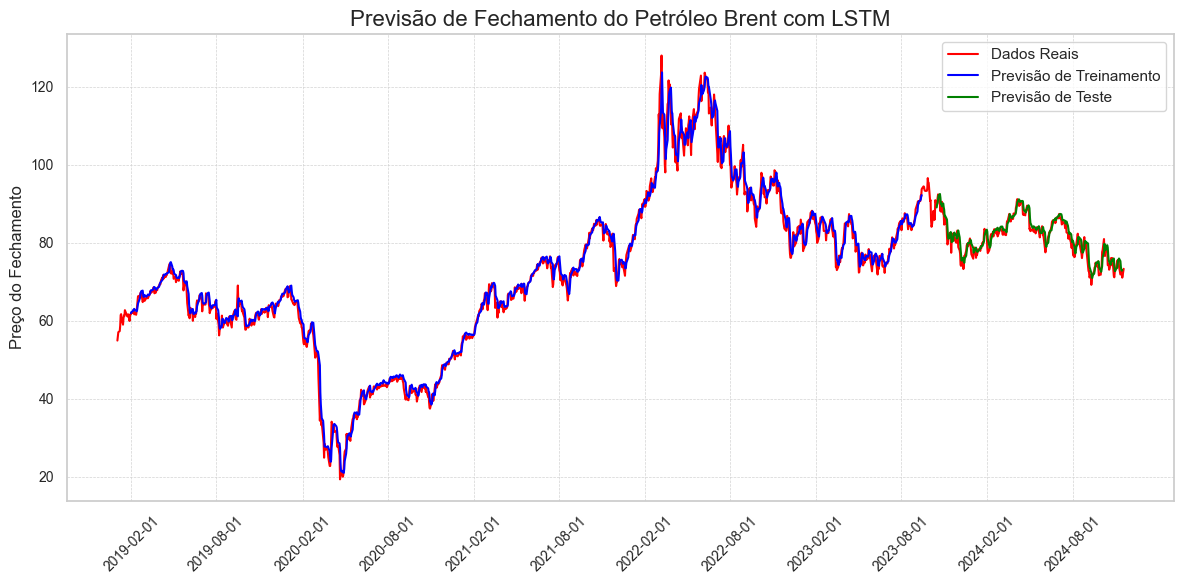

In [159]:
# Preparar os dados para o gráfico
train_predict_plot = np.empty_like(scaled_data[:, 0])
train_predict_plot[:] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step] = train_predict

test_predict_plot = np.empty_like(scaled_data[:, 0])
test_predict_plot[:] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1] = test_predict

# Criar o gráfico com melhorias visuais
plt.figure(figsize=(12, 6))
plt.plot(df_close.index, scaler.inverse_transform(scaled_data)[:, 0], label='Dados Reais', color='red')
plt.plot(df_close.index, train_predict_plot, label='Previsão de Treinamento', color='blue')
plt.plot(df_close.index, test_predict_plot, label='Previsão de Teste', color='green')
plt.title('Previsão de Fechamento do Petróleo Brent com LSTM', fontsize=16)
# plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço do Fechamento', fontsize=12)

# Ajustar os ticks do eixo x para exibir semestres
plt.xticks(
    pd.date_range(start=df_close.index.min(), end=df_close.index.max(), freq='6MS'),
    rotation=45,
    fontsize=10
)

# Linhas de grade
plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5, color='lightgray')

# Ajustar os ticks do eixo y
plt.yticks(fontsize=10)

# Adicionando uma legenda
plt.legend()

# Melhorar o layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()

## Avaliação do Modelo

Após treinar nosso modelo, é importante avaliá-lo para entender o quão bem ele está performando. Utilizamos várias métricas de precisão comuns para julgar as previsões:

* `MAE` (Erro Absoluto Médio): Mostra a diferença média entre as previsões e os valores reais, ignorando a direção. Quanto menor, melhor.
* `RMSE` (Raiz do Erro Quadrático Médio): Semelhante ao MAE, mas dá mais peso aos erros grandes. Isso o torna particularmente útil quando grandes erros são indesejáveis.
* `MAPE` (Erro Percentual Absoluto Médio): Expressa o erro como uma porcentagem do valor real. Útil para comparações diretas entre séries temporais de diferentes escalas.
* `R²` (Coeficiente de Determinação): Indica a proporção da variação dos dados que é previsível pelo modelo. Valores mais próximos de 1 indicam um modelo muito bom.

In [160]:
# Calcular métricas de erro

rmse = np.sqrt(mean_squared_error(y_test, test_predict))
mae = mean_absolute_error(y_test, test_predict)
r2 = r2_score(y_test, test_predict)
mape = mean_absolute_percentage_error(y_test, test_predict)

print(f'RMSE: {rmse:}')
print(f'MAE: {mae:}')
print(f'MAPE: {mape:}')
print(f'R2: {r2:.2%}')


RMSE: 1.7515293271508743
MAE: 1.3263127536904433
MAPE: 0.016681423935192428
R2: 88.27%


### Análise dos Indicadores

* RMSE: 1.7515 -> Indica um desvio médio baixo entre as previsões e os valores reais, mostrando boa precisão.

* MAE: 1.3263 -> Reflete erros absolutos médios baixos, reforçando a precisão do modelo.

* MAPE: 1.67% -> Sugere que os erros de previsão são apenas 1.67% dos valores reais, indicando alta precisão percentual.

* R²: 88.27% -> Revela que o modelo explica 88.27% da variabilidade nos dados, demonstrando eficácia na captura de tendências.

**Conclusão:**
O modelo LSTM apresenta excelente desempenho, com baixa margem de erro e alta capacidade de explicação das variações nos dados, tornando-o confiável para previsões do preço de fechamento do Petróleo Brent.

# Justificativa para Não Utilizar Variáveis Exógenas na Previsão

Durante a análise exploratória dos dados, consideramos a utilização de variáveis exógenas, como o `Dólar` e o `Volume`, para potencialmente melhorar a previsão do preço de fechamento do petróleo Brent. No entanto, após avaliações detalhadas, optamos por não incluir essas variáveis exógenas no modelo de previsão final. A decisão foi baseada nos seguintes pontos:

* **Desempenho do Modelo**: O modelo apresentou um desempenho robusto ao prever o preço de fechamento do petróleo Brent usando apenas a variável `Close`. A simplicidade do modelo, aliada à sua eficácia, sugere que a inclusão de variáveis adicionais não traria melhorias significativas.

* **Complexidade Adicional**: A introdução de variáveis exógenas como o Dólar e o Volume poderia aumentar a complexidade do modelo sem oferecer ganhos substanciais em termos de precisão. Manter o modelo mais simples facilita a interpretação e a manutenção.

* **Eficiência Computacional**: Modelos com menos variáveis tendem a ser mais rápidos e eficientes em termos computacionais. Optar por uma abordagem mais enxuta permite previsões mais rápidas, o que é benéfico para aplicações em tempo real.

Portanto, decidimos focar na variável `Close` para a previsão, garantindo um modelo eficiente e eficaz para o nosso objetivo.

# Salvando o Modelo LSTM para uso no Streamlit

Para garantir que o modelo LSTM possa ser reutilizado e implementado em outras aplicações, como o Streamlit, é essencial salvá-lo adequadamente. Aqui, o modelo é salvo no formato Keras, que facilita o carregamento e a implementação. 

Ao salvar o modelo no formato .keras, estamos assegurando que todos os detalhes do modelo, incluindo a arquitetura, os pesos e a configuração de treinamento, sejam preservados. Isso permite que o modelo seja facilmente carregado e utilizado para previsões sem a necessidade de re-treinamento.

In [161]:
# Salvar o modelo no formato keras
model.save('lstm_model.keras')